

1.   Go to https://drive.google.com/drive/folders/1j5jrtQ2zIuSRyIPni2tVmyU1SEB-VORz?usp=sharing
2.   Make a copy of minor.zip
3.   Move the copy to your own drive
4.   Rename the copy back to minor.zip
5.   Change the `unzip` path from `/content/drive/MyDrive/VIP/minor.zip` to the saved location.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/VIP/minor.zip

In [3]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt 

import albumentations as A
import torch
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch.transforms import ToTensorV2
from albumentations import RandomCrop

In [4]:
with open("Minor/train.txt","r+") as f0:
  train_list = f0.read().split("\n")

with open("Minor/val.txt","r+") as f0:
  val_list = f0.read().split("\n")

with open("Minor/test.txt","r+") as f0:
  test_list = f0.read().split("\n")

labels = pd.read_csv("Minor/labels.csv")

In [5]:
def construct_dataloder(dataset, batch_size, shuffle=True, num_workers=4):
    return DataLoader(dataset, batch_size=batch_size,
                      shuffle=shuffle, num_workers=num_workers)

class VIPDataset(Dataset):
    def __init__(self, file_ids, labels, data_dir,):
        self.file_ids = file_ids
        self.labels = labels
        self.data_dir = data_dir
        self.aug = transform = A.Compose([
            A.augmentations.geometric.resize.RandomScale(scale_limit=[0,2],interpolation=cv.INTER_LINEAR,p=0.3),
            A.augmentations.transforms.ImageCompression(quality_lower=99, quality_upper=100, always_apply=False, p=0.3),
            # A.augmentations.crops.transforms.RandomCrop(width=200, height=200,p=1)
        ])
        self.trans = A.Compose([RandomCrop(width=200, height=200,p=1), ToTensorV2()])

    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, index):
        image_id = self.file_ids[index]
        x = np.array(Image.open(os.path.join(self.data_dir, image_id)))
        x = self.aug(image=x)['image']
        x = self.trans(image=x)['image']
        y = int(self.labels.loc[self.labels["image_ids"] == image_id,"label"])
        return x, torch.from_numpy(np.array(y))

    def augment(self, x):
        """Augmentations for images"""
        return self.aug_pipeline(image=x)["image"]

In [6]:
train_ds = VIPDataset(train_list,labels,"Minor/data")
val_ds = VIPDataset(val_list,labels,"Minor/data")
test_ds = VIPDataset(test_list,labels,"Minor/data")

In [7]:
train_dl = construct_dataloder(train_ds, 8, shuffle=True, num_workers=2)
val_dl = construct_dataloder(val_ds, 8, shuffle=True, num_workers=2)
test_dl = construct_dataloder(test_ds, 8, shuffle=True, num_workers=2)

7670 torch.Size([3, 200, 200]) torch.Size([])
tensor(0)
8237 torch.Size([3, 200, 200]) torch.Size([])
tensor(0)
1950 torch.Size([3, 200, 200]) torch.Size([])
tensor(1)
2432 torch.Size([3, 200, 200]) torch.Size([])
tensor(1)


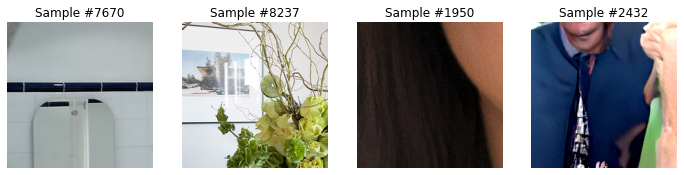

In [8]:
plt.figure(figsize=(12,4))
for j, i in enumerate(random.sample(set(range(len(train_ds))), 4)):
    sample_image, sample_label = train_ds[i]
    print(i, sample_image.shape, sample_label.shape)

    ax = plt.subplot(1, 4, j + 1)
#     plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(np.transpose(sample_image, (1, 2, 0)))
    print(sample_label)
    if i == 3:
        plt.show()
        break

In [15]:
! pip install neptune-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 30.0 MB/s 
     |████████████████████████████████| 829 kB 54.2 MB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |████████████████████████████████| 181 kB 61.8 MB/s 
     |████████████████████████████████| 132 kB 63.5 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 79 kB 8.9 MB/s 
     |████████████████████████████████| 9.0 MB 66.7 MB/s 
     |████████████████████████████████| 139 kB 74.3 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 127 kB 76.1 MB/s 
     |████████████████████████████████| 67 kB 6.1 MB/s 
     |████████████████████████████████| 130 kB 70.5 MB/s 
     |████████████████████████████████| 80 kB 10.2 MB/s 
     |████████████████████████████████| 79 kB 10.1 MB/s 
     |████████████████████████████████| 79 

In [19]:
import neptune.new as neptune
run = neptune.init(
    project="Botz/VIPCup-logs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)

https://app.neptune.ai/Botz/VIPCup-logs/e/VIP-13
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [9]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 30.0 MB/s 


In [12]:
from torchmetrics import Recall, Precision, F1Score, Accuracy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
metrics = {
    'accuracy': Accuracy(num_classes=2, average='macro').to(device),
    'recall': Recall(num_classes=2, average='macro').to(device),
    'precision': Precision(num_classes=2, average='macro').to(device),
    'f1_score': F1Score(num_classes=2, average='macro').to(device)
}

{'accuracy': Accuracy(), 'recall': Recall(), 'precision': Precision(), 'f1_score': F1Score()}


In [ ]:
# Script Parameters

MODEL_NAME = 'resnet'
# MODEL_NAME = 'vgg'

SOFTMAX = False

BATCH_SIZE = 16
EPOCHS = 5
LR = 0.001

USE_REG= True
REG_STRENGTH = 0

USE_NOISE = False
NOISE_TYPE = 'Gaussian'
NOISE_1 = 0
NOISE_2 = 0

params = {
    "Model-Name": 'Adversarial Perturbations',
    'Dataset-Name': 'Combined datasetv1',
    'note': 'Enable regularization',
    "backbone_model": "resnet",
    "output_type": "softmax" if SOFTMAX else "sigmoid",
    "batch_size": BATCH_SIZE,
    "learning_rate": LR, 
    "optimizer": "SGD",
    "use_reg": USE_REG,
    "use_noise": USE_NOISE
}
run["parameters"] = params

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from torch.autograd import Variable

def lipshitz_regularization(images, model, z=2, train=True, psi=1000, use_softmax=SOFTMAX, num_classes = 2):
    if use_softmax:
      repeated_images = images.repeat(num_classes, 1, 1, 1, 1)
      repeated_output = torch.stack([model(repeated_images[0]).sum(axis=0), model(repeated_images[1]).sum(axis=0)])
      grads = torch.autograd.grad(repeated_output, repeated_images, grad_outputs=torch.eye(num_classes).to(device), create_graph=train)[0]
    else:
      grads = torch.autograd.grad(model(images).sum(), images, create_graph=train)[0]
    return psi*grads.abs().pow(z).mean()

def add_noise(input, noise_type=NOISE_TYPE, noise1=NOISE_1, noise2=NOISE_2):
  if noise_type == 'Gaussian':
    noise = Variable(input.data.new(input.size()).normal_(noise1, noise2))
    return torch.clamp(input + noise, 0, 1)  
  elif noise_type == 'Cauchy':
    noise = Variable(input.data.new(input.size()).cauchy_(noise1, noise2))
    return torch.clamp(input + noise, 0, 1)  
  elif noise_type == 'Uniform': 
    noise = Variable(input.data.new(input.size()).uniform_(noise1, noise2))
    return torch.clamp(input + noise, 0, 1)  
  return input

def train_model(model, criterion, optimizer, scheduler, use_reg=USE_REG, num_epochs=EPOCHS, use_noise=USE_NOISE, use_softmax=SOFTMAX):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    record_list = list(metrics.keys())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            recorder = {metric: [] for metric in record_list}
            for inputs, labels in tqdm(dataloaders[phase]):
                if phase == 'train' and use_noise:
                    inputs = add_noise(inputs)

                inputs = inputs.to(device).float()
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward (track history if only in train)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    if use_softmax:
                      _, preds = torch.max(outputs, 1)
                      loss = criterion(outputs, labels)
                    else:
                      preds = torch.where(outputs.squeeze() > 0, torch.ones(len(outputs)).to(device), torch.zeros(len(outputs)).to(device)).long()
                      loss = criterion(outputs, labels.unsqueeze(1).float())

                    if phase == 'train':
                      if use_softmax:
                        loss = criterion(outputs, labels)
                      else:
                        loss = criterion(outputs, labels.unsqueeze(1).float())
                      
                      if use_reg:
                        inputs.requires_grad = True
                        reg = lipshitz_regularization(inputs, model)
                        inputs.requires_grad = False
                        loss = loss + reg

                      loss.backward()
                      optimizer.step()
                    else:
                      if use_softmax:
                        loss = criterion(outputs, labels)
                      else:
                        loss = criterion(outputs, labels.unsqueeze(1).float())

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                for i in record_list:
                  recorder[i].append(metrics[i](preds, labels.data))

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            for i in record_list:
                run[f'{phase}/{i}'].log(sum(recorder[i])/len(recorder[i]))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            for i in record_list:
                print(f'{i}: {sum(recorder[i])/len(recorder[i])}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

transformation = transforms.Compose([transforms.ToTensor()])

train_data = train_ds   # datasets.ImageFolder(root=TRAIN_DIR, transform=transformation)
val_data = val_ds   # datasets.ImageFolder(root=VAL_DIR, transform=transformation)

dataloaders = {} 
dataloaders['train'] = train_dl   # torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
dataloaders['val'] = val_dl   # torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

dataset_sizes = {}
dataset_sizes['train'] = len(train_data)
dataset_sizes['val'] = len(val_data)

class_names = [0, 1]

if 'vgg' in MODEL_NAME:
  model_ft = models.vgg16(pretrained=True)
  num_ftrs = model_ft.classifier[6].in_features
  model_ft.classifier[6] = nn.Linear(num_ftrs, 2 if SOFTMAX else 1)
elif 'resnet' in MODEL_NAME:
  model_ft = models.resnet18(pretrained=True)
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Linear(num_ftrs, 2 if SOFTMAX else 1)

if SOFTMAX:
  criterion = nn.CrossEntropyLoss()
else:
  criterion = nn.BCEWithLogitsLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=LR, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = train_model(model_ft.to(device), criterion, optimizer_ft, exp_lr_scheduler)

Epoch 0/4
----------


100%|██████████| 1515/1515 [05:19<00:00,  4.74it/s]


train Loss: 0.6082 Acc: 0.6773
accuracy: 0.6997807621955872
recall: 0.6997807621955872
precision: 0.6974371075630188
f1_score: 0.653749406337738


100%|██████████| 217/217 [00:36<00:00,  6.01it/s]


val Loss: 0.4981 Acc: 0.7549
accuracy: 0.7499696016311646
recall: 0.7499696016311646
precision: 0.7437677979469299
f1_score: 0.7237420082092285

Epoch 1/4
----------


100%|██████████| 1515/1515 [05:11<00:00,  4.86it/s]


train Loss: 0.5548 Acc: 0.7147
accuracy: 0.7389755845069885
recall: 0.7389755845069885
precision: 0.7358828783035278
f1_score: 0.6949703097343445


100%|██████████| 217/217 [00:36<00:00,  5.91it/s]


val Loss: 0.4715 Acc: 0.7728
accuracy: 0.7753647565841675
recall: 0.7753647565841675
precision: 0.774448573589325
f1_score: 0.7468175888061523

Epoch 2/4
----------


100%|██████████| 1515/1515 [05:06<00:00,  4.94it/s]


train Loss: 0.5267 Acc: 0.7356
accuracy: 0.7633894681930542
recall: 0.7633894681930542
precision: 0.7544212341308594
f1_score: 0.7179685831069946


100%|██████████| 217/217 [00:35<00:00,  6.16it/s]


val Loss: 0.4716 Acc: 0.7687
accuracy: 0.7738094925880432
recall: 0.7738094925880432
precision: 0.7674455046653748
f1_score: 0.740625262260437

Epoch 3/4
----------


100%|██████████| 1515/1515 [05:07<00:00,  4.93it/s]


train Loss: 0.4990 Acc: 0.7595
accuracy: 0.787551999092102
recall: 0.787551999092102
precision: 0.7777247428894043
f1_score: 0.7449467778205872


100%|██████████| 217/217 [00:35<00:00,  6.11it/s]


val Loss: 0.4338 Acc: 0.7976
accuracy: 0.7949420809745789
recall: 0.7949420809745789
precision: 0.7915101647377014
f1_score: 0.7698414325714111

Epoch 4/4
----------


100%|██████████| 1515/1515 [05:03<00:00,  4.99it/s]


train Loss: 0.4745 Acc: 0.7717
accuracy: 0.7960939407348633
recall: 0.7960939407348633
precision: 0.7861893177032471
f1_score: 0.7554731965065002


100%|██████████| 217/217 [00:35<00:00,  6.19it/s]

val Loss: 0.4496 Acc: 0.7866
accuracy: 0.7897573709487915
recall: 0.7897573709487915
precision: 0.7913867831230164
f1_score: 0.7639462351799011

Training complete in 28m 48s
Best Val Acc: 0.797578


In [28]:
# Change model save path to the preferred save location
import time
torch.save(model_ft, f"/content/drive/MyDrive/VIP/model_{int(time.time())}")

In [29]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/Botz/VIPCup-logs/e/VIP-13
